# Chapter 7: <i>k</i>-Nearest Neighbors (<i>k</i>NN)

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import matplotlib.pylab as plt
import numpy as np

In [3]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('/Users/min/OneDrive/teaching/DS110/dmba/')
# DATA = Path('C:/Users/profm/OneDrive/teaching/DS110/dmba/')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

## Table 7.1

In [11]:
mower_df = pd.read_csv(DATA / 'RidingMowers.csv')
mower_df['Number'] = mower_df.index + 1
mower_df

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,1
1,85.5,16.8,Owner,2
2,64.8,21.6,Owner,3
3,61.5,20.8,Owner,4
4,87.0,23.6,Owner,5
5,110.1,19.2,Owner,6
6,108.0,17.6,Owner,7
7,82.8,22.4,Owner,8
8,69.0,20.0,Owner,9
9,93.0,20.8,Owner,10


In [12]:
trainData, validData = train_test_split(mower_df, test_size=0.4, random_state=1)
print(trainData.shape, validData.shape)

(14, 4) (10, 4)


In [13]:
newHousehold = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}])
newHousehold

,Income,Lot_Size
0,60,20


In [14]:
trainData

,Income,Lot_Size,Ownership,Number
6,108.0,17.6,Owner,7
7,82.8,22.4,Owner,8
21,33.0,18.8,Nonowner,22
1,85.5,16.8,Owner,2
16,84.0,17.6,Nonowner,17
0,60.0,18.4,Owner,1
15,43.2,20.4,Nonowner,16
23,63.0,14.8,Nonowner,24
22,51.0,14.0,Nonowner,23
9,93.0,20.8,Owner,10


In [15]:
validData

,Income,Lot_Size,Ownership,Number
13,52.8,20.8,Nonowner,14
18,59.4,16.0,Nonowner,19
3,61.5,20.8,Owner,4
14,64.8,17.2,Nonowner,15
20,47.4,16.4,Nonowner,21
17,49.2,17.6,Nonowner,18
10,51.0,22.0,Owner,11
4,87.0,23.6,Owner,5
2,64.8,21.6,Owner,3
19,66.0,18.4,Nonowner,20


Scatter plot

In [16]:
trainData[['Income', 'Lot_Size']]

,Income,Lot_Size
6,108.0,17.6
7,82.8,22.4
21,33.0,18.8
1,85.5,16.8
16,84.0,17.6
0,60.0,18.4
15,43.2,20.4
23,63.0,14.8
22,51.0,14.0
9,93.0,20.8


In [17]:
trainData.loc[:,['Income', 'Lot_Size']]

,Income,Lot_Size
6,108.0,17.6
7,82.8,22.4
21,33.0,18.8
1,85.5,16.8
16,84.0,17.6
0,60.0,18.4
15,43.2,20.4
23,63.0,14.8
22,51.0,14.0
9,93.0,20.8


## Table 7.2
Initialize normalized training, validation, and complete data frames. Use the training data to learn the transformation.

In [18]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Income', 'Lot_Size']])  # Note the use of an array of column names
# In scikit-learn estimator api, 
# fit(): used for generating learning model parameters from training data 
# transform(): parameters generated from fit() method, applied upon model to generate transformed data set. 
# fit_transform(): combination of fit() and transform() api on same data set

# Transform the full dataset
mowerNorm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]), 
                                    columns=['zIncome', 'zLot_Size']),
                       mower_df[['Ownership', 'Number']]], axis=1)
trainNorm = mowerNorm.iloc[trainData.index]
validNorm = mowerNorm.iloc[validData.index]
newHouseholdNorm = pd.DataFrame(scaler.transform(newHousehold), columns=['zIncome', 'zLot_Size'])

In [19]:
mowerNorm

,zIncome,zLot_Size,Ownership,Number
0,-0.649419,-0.090272,Owner,1
1,0.517966,-0.812447,Owner,2
2,-0.429676,1.354078,Owner,3
3,-0.580750,0.992991,Owner,4
4,0.586635,2.256797,Owner,5
5,1.644149,0.270816,Owner,6
6,1.548011,-0.451359,Owner,7
7,0.394360,1.715166,Owner,8
8,-0.237401,0.631903,Owner,9
9,0.861314,0.992991,Owner,10


In [20]:
trainNorm

,zIncome,zLot_Size,Ownership,Number
6,1.548011,-0.451359,Owner,7
7,0.394360,1.715166,Owner,8
21,-1.885474,0.090272,Nonowner,22
1,0.517966,-0.812447,Owner,2
16,0.449296,-0.451359,Nonowner,17
0,-0.649419,-0.090272,Owner,1
15,-1.418520,0.812447,Nonowner,16
23,-0.512080,-1.715166,Nonowner,24
22,-1.061437,-2.076253,Nonowner,23
9,0.861314,0.992991,Owner,10


In [21]:
validNorm

,zIncome,zLot_Size,Ownership,Number
13,-0.979034,0.992991,Nonowner,14
18,-0.676887,-1.173534,Nonowner,19
3,-0.580750,0.992991,Owner,4
14,-0.429676,-0.631903,Nonowner,15
20,-1.226245,-0.992991,Nonowner,21
17,-1.143841,-0.451359,Nonowner,18
10,-1.061437,1.534622,Owner,11
4,0.586635,2.256797,Owner,5
2,-0.429676,1.354078,Owner,3
19,-0.374740,-0.090272,Nonowner,20


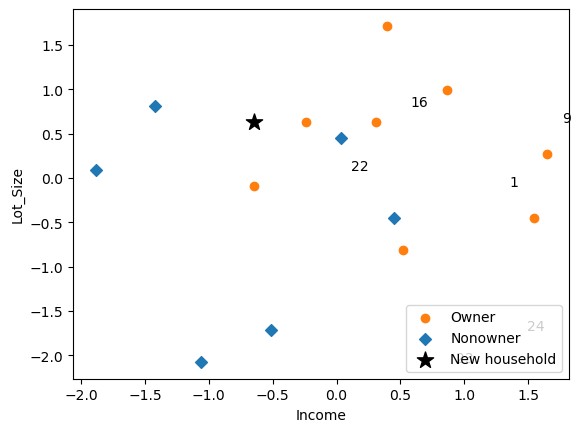

In [26]:
fig, ax = plt.subplots()

subset = trainNorm.loc[trainNorm['Ownership']=='Owner']
ax.scatter(subset.zIncome, subset.zLot_Size, marker='o', label='Owner', color='C1')

subset = trainNorm.loc[trainNorm['Ownership']=='Nonowner']
ax.scatter(subset.zIncome, subset.zLot_Size, marker='D', label='Nonowner', color='C0')

ax.scatter(newHouseholdNorm.zIncome, newHouseholdNorm.zLot_Size, marker='*', label='New household', color='black', s=150)

plt.xlabel('Income')  # set x-axis label
plt.ylabel('Lot_Size')  # set y-axis label
for _, row in trainNorm.iterrows():
    ax.annotate(row.Number, (row.zIncome + 2, row.zLot_Size))
    
handles, labels = ax.get_legend_handles_labels()
#ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

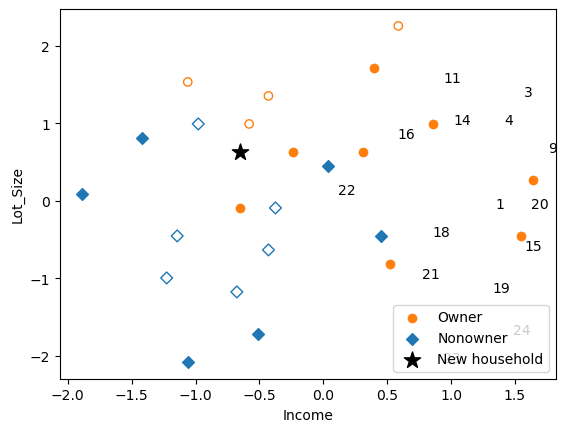

In [28]:
# *kwargs allows you to pass keyworded variable length of arguments to a function. 
# You should use **kwargs if you want to handle named arguments in a function. 

def plotDataset(ax, data, showLabel=True, **kwargs):
    subset = data.loc[data['Ownership']=='Owner']
    ax.scatter(subset.zIncome, subset.zLot_Size, marker='o', label='Owner' if showLabel else None, color='C1', **kwargs)

    subset = data.loc[data['Ownership']=='Nonowner']
    ax.scatter(subset.zIncome, subset.zLot_Size, marker='D', label='Nonowner' if showLabel else None, color='C0', **kwargs)

    plt.xlabel('Income')  # set x-axis label
    plt.ylabel('Lot_Size')  # set y-axis label
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.zIncome + 2, row.zLot_Size))

fig, ax = plt.subplots()

plotDataset(ax, trainNorm)
plotDataset(ax, validNorm, showLabel=False, facecolors='none')

ax.scatter(newHouseholdNorm.zIncome, newHouseholdNorm.zLot_Size, marker='*', label='New household', color='black', s=150)

plt.xlabel('Income')  # set x-axis label
plt.ylabel('Lot_Size')  # set y-axis label

# add legend: Owner, Nonowner, New household
handles, labels = ax.get_legend_handles_labels()
# see https://matplotlib.org/xkcd/users/legend_guide.html
# ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)
plt.show()

In [17]:
newHouseholdNorm

,zIncome,zLot_Size
0,-0.649419,0.631903


Use k-nearest neighbour

In [18]:
# try k=3 neighbors in the training data
knn = NearestNeighbors(n_neighbors=3)
# https://scikit-learn.org/stable/modules/neighbors.html#neighbors
knn.fit(trainNorm[['zIncome', 'zLot_Size']])
distances, indices = knn.kneighbors(newHouseholdNorm)
# kneighbors([X, n_neighbors, return_distance]) Finds the K-neighbors of a point.
# see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
print(trainNorm.iloc[indices[0], :])  # indices is a list of lists, we are only interested in the first element

     zIncome  zLot_Size Ownership  Number
8  -0.237401   0.631903     Owner       9
12  0.037278   0.451359  Nonowner      13
0  -0.649419  -0.090272     Owner       1


In [19]:
trainNorm

,zIncome,zLot_Size,Ownership,Number
6,1.548011,-0.451359,Owner,7
7,0.394360,1.715166,Owner,8
21,-1.885474,0.090272,Nonowner,22
1,0.517966,-0.812447,Owner,2
16,0.449296,-0.451359,Nonowner,17
0,-0.649419,-0.090272,Owner,1
15,-1.418520,0.812447,Nonowner,16
23,-0.512080,-1.715166,Nonowner,24
22,-1.061437,-2.076253,Nonowner,23
9,0.861314,0.992991,Owner,10


In [20]:
distances

array([[0.41201824, 0.71003443, 0.72217496]])

In [21]:
indices

array([[10, 11,  5]])

## Table 7.3
Initialize a data frame with two columns: `k` and `accuracy`

In [22]:
train_X = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_X = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

# Train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1       0.6
1    2       0.8
2    3       0.6
3    4       0.8
4    5       0.9
5    6       0.8
6    7       0.7
7    8       0.9
8    9       0.9
9   10       0.9
10  11       0.8
11  12       0.8
12  13       0.4
13  14       0.4


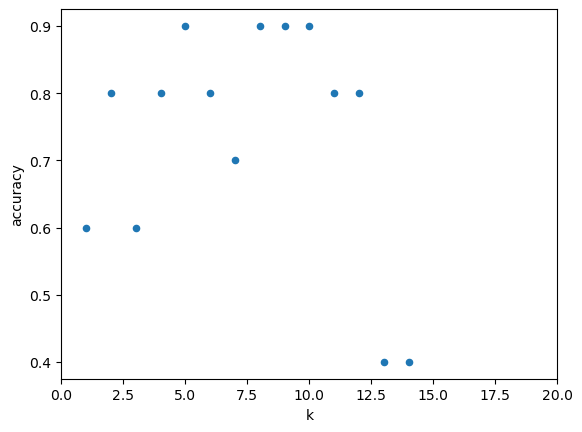

In [23]:
# plot accuracy vs. k
_ = results.plot.scatter(x='k', y='accuracy', xlim=[0, 20])

In [24]:
results.sort_values(by='accuracy', ascending=False)

,k,accuracy
4,5,0.9
7,8,0.9
8,9,0.9
9,10,0.9
1,2,0.8
3,4,0.8
5,6,0.8
10,11,0.8
11,12,0.8
6,7,0.7


## Table 7.4

In [25]:
# Retrain with full dataset for 5 neighbors
mower_X = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors=5).fit(mower_X, mower_y)
distances, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))

['Owner']


In [26]:
# The predicted probability of Nonowner is 0.4 and the predicted probability of Owner is 0.6
knn.predict_proba(newHouseholdNorm)

array([[0.4, 0.6]])

In [27]:
print('Distances',distances)
print('Indices', indices)
print(mowerNorm.iloc[indices[0], :])

Distances [[0.36755911 0.41201824 0.48890689 0.71003443 0.72217496]]
Indices [[ 3  8 13 12  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.580750   0.992991     Owner       4
8  -0.237401   0.631903     Owner       9
13 -0.979034   0.992991  Nonowner      14
12  0.037278   0.451359  Nonowner      13
0  -0.649419  -0.090272     Owner       1


In [28]:
classificationSummary(valid_y, knn.predict(valid_X))

Confusion Matrix (Accuracy 0.9000)

       Prediction
Actual 0 1
     0 5 1
     1 0 4


In [29]:
print('Confusion Matrix \n', confusion_matrix(valid_y, knn.predict(valid_X)))

Confusion Matrix 
 [[5 1]
 [0 4]]


In [30]:
print('Accuracy :', accuracy_score(valid_y, knn.predict(valid_X)))

Accuracy : 0.9


<h3><i>k</i>-NN Regression</h3>

In [31]:
from sklearn import (datasets, linear_model, model_selection as skms, metrics,neighbors)
diabetes = datasets.load_diabetes()

In [32]:
diabetes

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990749, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06833155, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286131, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04688253,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452873, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00422151,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [33]:
tts = skms.train_test_split(diabetes.data, diabetes.target, test_size=.25)

In [34]:
(diabetes_train_ftrs, diabetes_test_ftrs, diabetes_train_tgt, diabetes_test_tgt) = tts

In [35]:
diabetes_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
diabetes_df['target'] = diabetes.target
diabetes_df.head()
# bmi: body mass index
# bp: blood pressure
# s1-s6 are six blood serum measurements
# target is a numerical score measuring the progression of a patient's illness

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [36]:
knn = KNeighborsRegressor(n_neighbors=3)
fit = knn.fit(diabetes_train_ftrs, diabetes_train_tgt)
preds = fit.predict(diabetes_test_ftrs)
mse=metrics.mean_squared_error(diabetes_test_tgt, preds)

In [37]:
mse

4429.218218218218

In [38]:
rmse = np.sqrt(mse)
rmse

66.55237199543092

In [39]:
diabetes_df['target'].max() - diabetes_df['target'].min()

321.0

In [40]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [41]:
digits.target[::100]

array([0, 4, 1, 7, 4, 8, 2, 2, 4, 4, 1, 9, 7, 3, 2, 1, 2, 5])

In [42]:
digits.data.shape

(1797, 64)

In [43]:
digits.target.shape

(1797,)

In [44]:
digits.images[13]

array([[ 0.,  2.,  9., 15., 14.,  9.,  3.,  0.],
       [ 0.,  4., 13.,  8.,  9., 16.,  8.,  0.],
       [ 0.,  0.,  0.,  6., 14., 15.,  3.,  0.],
       [ 0.,  0.,  0., 11., 14.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  2., 15., 11.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2., 15.,  4.,  0.],
       [ 0.,  1.,  5.,  6., 13., 16.,  6.,  0.],
       [ 0.,  2., 12., 12., 13., 11.,  0.,  0.]])

In [45]:
digits.images[22]

array([[ 0.,  0.,  8., 16.,  5.,  0.,  0.,  0.],
       [ 0.,  1., 13., 11., 16.,  0.,  0.,  0.],
       [ 0.,  0., 10.,  0., 13.,  3.,  0.,  0.],
       [ 0.,  0.,  3.,  1., 16.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  9., 12.,  0.,  0.,  0.],
       [ 0.,  0.,  3., 15.,  5.,  0.,  0.,  0.],
       [ 0.,  0., 14., 15.,  8.,  8.,  3.,  0.],
       [ 0.,  0.,  7., 12., 12., 12., 13.,  1.]])

In [46]:
digits.target[22]

2

In [47]:
import matplotlib.pyplot as plt

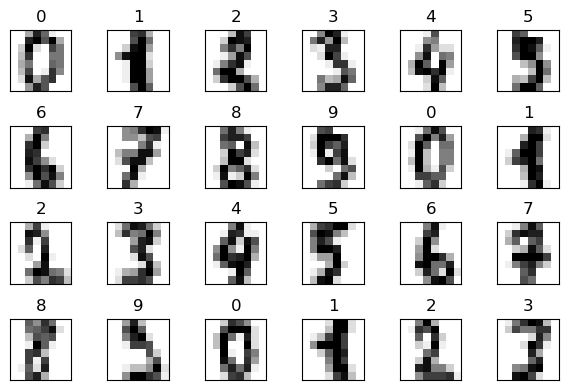

In [48]:
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(6, 4))

### Displaying Each Image and Removing the Axes Labels 

for item in zip(axes.ravel(), digits.images, digits.target):
    axes, image, target = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])  # remove x-axis tick marks
    axes.set_yticks([])  # remove y-axis tick marks
    axes.set_title(target)
plt.tight_layout()  

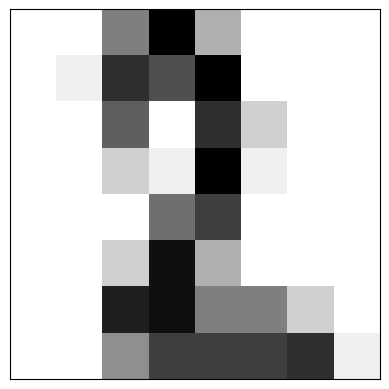

In [49]:
axes = plt.subplot()
image = plt.imshow(digits.images[22], cmap=plt.cm.gray_r)
xticks = axes.set_xticks([])
yticks = axes.set_yticks([])

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# Function train_test_split() returns a tuple of four elements in which the first two are the samples split into training and testing sets, 
# and the last two are the corresponding target values split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
     digits.data, digits.target, random_state=1)

In [52]:
# By default, 75% for training and 25% for test
X_train.shape

(1347, 64)

In [53]:
X_test.shape

(450, 64)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.40)

In [55]:
X_train.shape

(1078, 64)

In [56]:
X_test.shape

(719, 64)

### In the <i>k</i>-nearest neighbors algorithm, <i>k</i> is a hyperparameter, The process of choosing the best value of <i>k</i> for the <i>k</i>-nearest neighbors algorithm is called <b>hyperparameter tuning</b>.

In [57]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
knn = KNeighborsClassifier()

In [59]:
knn.fit(X=X_train, y=y_train)

KNeighborsClassifier()

In [60]:
predicted = knn.predict(X=X_test)

In [61]:
expected = y_test

In [62]:
predicted[:20]

array([9, 2, 9, 3, 3, 8, 4, 2, 5, 7, 9, 1, 1, 8, 2, 5, 9, 0, 1, 4])

In [63]:
expected[:20]

array([9, 2, 9, 3, 3, 8, 4, 2, 5, 7, 9, 1, 1, 8, 2, 5, 9, 0, 1, 4])

In [64]:
wrong = [(p, e) for (p, e) in zip(predicted, expected) if p != e]
wrong

[(9, 5),
 (5, 9),
 (7, 4),
 (7, 9),
 (8, 3),
 (1, 8),
 (3, 8),
 (7, 4),
 (5, 9),
 (7, 4),
 (7, 3),
 (3, 9)]

In [65]:
print(f'{(len(expected) - len(wrong)) / len(expected):.2%}')

98.33%


In [66]:
wrong = []
for p, e in zip(predicted, expected):
      if p != e:
          wrong.append((p, e))
wrong

[(9, 5),
 (5, 9),
 (7, 4),
 (7, 9),
 (8, 3),
 (1, 8),
 (3, 8),
 (7, 4),
 (5, 9),
 (7, 4),
 (7, 3),
 (3, 9)]

In [67]:
print(f'{knn.score(X_test, y_test):.2%}')

98.33%


In [68]:
from sklearn.metrics import confusion_matrix

In [69]:
confusion = confusion_matrix(y_true=expected, y_pred=predicted)

In [70]:
confusion

array([[67,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 72,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 75,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 70,  0,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  0, 67,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0, 78,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 63,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 72,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  0, 64,  0],
       [ 0,  0,  0,  1,  0,  2,  0,  1,  0, 79]])

In [71]:
from sklearn.metrics import classification_report

In [72]:
names = [str(digit) for digit in digits.target_names]

In [73]:
print(classification_report(expected, predicted, 
       target_names=names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.99      1.00      0.99        72
           2       1.00      1.00      1.00        75
           3       0.97      0.97      0.97        72
           4       1.00      0.96      0.98        70
           5       0.97      0.99      0.98        79
           6       1.00      1.00      1.00        63
           7       0.94      1.00      0.97        72
           8       0.98      0.97      0.98        66
           9       0.99      0.95      0.97        83

    accuracy                           0.98       719
   macro avg       0.98      0.98      0.98       719
weighted avg       0.98      0.98      0.98       719



In [74]:
import pandas as pd

In [75]:
confusion_df = pd.DataFrame(confusion, index=range(10),
     columns=range(10))

In [76]:
import seaborn as sns

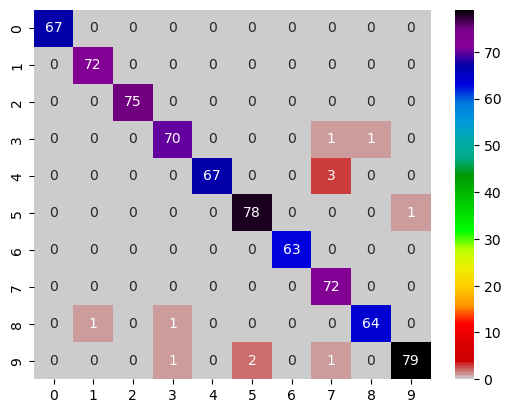

In [77]:
axes = sns.heatmap(confusion_df, annot=True, 
                    cmap='nipy_spectral_r')

In [78]:
from sklearn.model_selection import KFold

In [79]:
kfold = KFold(n_splits=10, random_state=1, shuffle=True)

In [80]:
from sklearn.model_selection import cross_val_score

In [81]:
scores = cross_val_score(estimator=knn, X=digits.data, 
     y=digits.target, cv=kfold)

In [82]:
scores

array([1.        , 0.98888889, 0.98888889, 0.96666667, 0.98333333,
       0.98888889, 0.98888889, 0.98882682, 0.98882682, 0.99441341])

In [83]:
print(f'Mean accuracy: {scores.mean():.2%}')

Mean accuracy: 98.78%


In [84]:
print(f'Accuracy standard deviation: {scores.std():.2%}')

Accuracy standard deviation: 0.82%


In [85]:
from sklearn.svm import SVC

In [86]:
from sklearn.naive_bayes import GaussianNB

In [87]:
estimators = {
     'KNeighborsClassifier': knn, 
     'SVC': SVC(gamma='scale'),
     'GaussianNB': GaussianNB()}

In [88]:
for estimator_name, estimator_object in estimators.items():
     kfold = KFold(n_splits=10, random_state=1, shuffle=True)
     scores = cross_val_score(estimator=estimator_object, 
         X=digits.data, y=digits.target, cv=kfold)
     print(f'{estimator_name:>20}: ' + 
           f'mean accuracy={scores.mean():.2%}; ' +
           f'standard deviation={scores.std():.2%}')

KNeighborsClassifier: mean accuracy=98.78%; standard deviation=0.82%
                 SVC: mean accuracy=98.89%; standard deviation=0.75%
          GaussianNB: mean accuracy=83.97%; standard deviation=2.40%


In [89]:
for k in range(1, 20, 2):
     kfold = KFold(n_splits=10, random_state=1, shuffle=True)
     knn = KNeighborsClassifier(n_neighbors=k)
     scores = cross_val_score(estimator=knn, 
         X=digits.data, y=digits.target, cv=kfold)
     print(f'k={k:<2}; mean accuracy={scores.mean():.2%}; ' +
           f'standard deviation={scores.std():.2%}')

k=1 ; mean accuracy=98.72%; standard deviation=0.70%
k=3 ; mean accuracy=98.83%; standard deviation=0.80%
k=5 ; mean accuracy=98.78%; standard deviation=0.82%
k=7 ; mean accuracy=98.50%; standard deviation=0.86%
k=9 ; mean accuracy=98.27%; standard deviation=1.01%
k=11; mean accuracy=98.39%; standard deviation=0.88%
k=13; mean accuracy=98.27%; standard deviation=0.98%
k=15; mean accuracy=98.05%; standard deviation=1.12%
k=17; mean accuracy=97.77%; standard deviation=1.14%
k=19; mean accuracy=97.55%; standard deviation=1.15%


In [90]:
import math

In [91]:
math.log(10)

2.302585092994046

In [92]:
math.log(math.e)

1.0

### Scikit-learn's machine-learning algorithms require samples to be stored in a <i>two-dimensional array</i> of <i>floating-point values</i> (or two-dimensional <i>array-like</i> collection, such as a list of lists or pandas DataFrame):
<ul>
    <li>Each row represents on <i>sample</i>.
    <li>Each column in a given row represents one <i>feature</i> for that sample.
    </ul>